In [1]:
import qtensor
import numpy as np
import cartesian_explorer as caex
import networkx as nx
import socket # used to determine hostname

import xarray as xar # used to store data-arrays: data + coords

Determine whether to use parallel caclulations based on hostname: don't run parallel jobs if executed on a home workstation

In [2]:
# Set up cache directory
cache = caex.caches.JobLibCache("../caex_cache")

# Set up parallel environment based on machine
if socket.gethostname().startswith('skylake'):
    print('Using ray parallel for caex')
    parallel = caex.parallels.Ray(processes=55)
else:
    # Cartesian explorer without parallelization
    parallel = None
ex = caex.Explorer(cache=cache, parallel=parallel)

Using ray parallel for caex


2021-06-13 16:35:17,955	INFO services.py:1090 -- View the Ray dashboard at http://127.0.0.1:8265


## Define variable providers

In [3]:
@ex.provider
def graph(N, seed=10):
    return nx.random_regular_graph(d=3, n=N, seed=seed)

@ex.provider
def bethe_params(p):
    gammabeta = qtensor.tools.BETHE_QAOA_VALUES[str(p)]['angles'] 
    gammabeta = np.array(gammabeta)
    gammabeta = gammabeta/np.pi
    gamma, beta = gammabeta[:p], gammabeta[p:]
    assert len(beta)==len(gamma), "Wrong parameters format, possibly unsolved p"
    return tuple(gamma), tuple(beta)
    

@ex.provider
def transfer_cost(graph, p, bethe_params):
    gamma, beta = bethe_params
    sim = qtensor.QAOAQtreeSimulator(qtensor.DefaultQAOAComposer, max_tw=32)
    try:
        transfer_cost = sim.energy_expectation(graph, gamma, beta)
        return transfer_cost
    except Exception as e:
        print(e)
        return None

## Generate data

In [4]:
# these values have to match ones from ./Optimal solutions with gurobi.ipynb
Ns = [2**x for x in range(3, 9)]
seeds = range(10, 10+32)

ps = [1, 2, 3, 4]
data = ex.map_variables(('transfer_cost',)
                        , p=ps
                        , ordering_algo=['rgreedy_0.02_10']
                        , N=Ns
                        , seed=seeds
                        )

/home/danlkv/.local/bin/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [5]:
data.shape

(1, 4, 6, 32)

In [6]:
xd = xar.DataArray(data[0], dims=('p', 'N', 'seed'), coords=(ps, Ns, seeds))

In [7]:
# Number of failed calculations
xd.data[xd.data==None]

array([None, None, None, None, None, None, None, None, None, None, None],
      dtype=object)

### Check the data

In [8]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Cost per node')

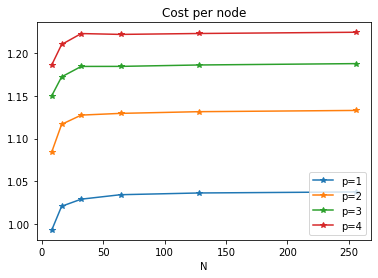

In [9]:
for p in ps:
    (xd.sel(p=p).mean('seed')/Ns).plot(marker='*', label=f'p={p}')
plt.legend()
plt.title('Cost per node')

In [10]:
xd.to_netcdf('../QAOA_cost_vs_N.nc')